In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import matplotlib.pyplot as plt

In [ ]:
"""
To ignore the pandas SettingWithCopyWarning in cell 5 function time_for_phase
If you have the solution to optimize the function please contact :)
"""
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from data_access.load_file import *
from data_processing.functions import *

Select the columns

In [4]:
relevant_columns = ["work_item", "work_type", "work_priority", "domain", "platform", "components", "timestamp", "process_phase"]

In [5]:
duration_type = ["duration_in_days"]

Compute times for every process phase

In [6]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
data.sort_values(by='timestamp', inplace=True)
data = add_phase(data, col_name="process_phase", cols=["from_phase", "to_phase"], as_str=False)
#data = add_phase(data, col_name="resource_phase", cols=["from_resource", "to_resource"], as_str=False)
times = time_for_phase(data, relevant_columns=relevant_columns, end_date=None)

Rename and order columns

In [7]:
times = add_phase(times, col_name="work_type_change", cols=["work_type_x", "work_type_y"])
times = add_phase(times, col_name="work_priority_change", cols=["work_priority_x", "work_priority_y"])
times = add_phase(times, col_name="domain_change", cols=["domain_x", "domain_y"])
times = add_phase(times, col_name="components_change", cols=["components_x", "components_y"])

In [8]:
new_names = {
            "to_phase": "current_phase",
            "process_phase_x": "process_change",
            "timestamp_x": "from_timestamp",
            "timestamp_y": "to_timestamp",
            "process_phase_y": "next_process"
            }
times.rename(columns=new_names, inplace=True)
relevant_cols = ["work_item", "process_index", "process_change", "work_type_change", "work_priority_change",
                 "domain_change", "components_change", "current_phase", "next_process", *duration_type]
times= times[relevant_cols]

In [9]:
times.head()

,work_item,process_index,process_change,work_type_change,work_priority_change,domain_change,components_change,current_phase,next_process,duration_in_days
0,WI_000001,1,"(Start, Analyze)","(WT_00001, WT_00001)","(WP_00003, WP_00003)","(BD_00001, BD_00001)","(nan, nan)",Analyze,"(Analyze, Design)",2.88
1,WI_000002,1,"(Start, Analyze)","(WT_00002, WT_00002)","(WP_00004, WP_00004)","(BD_00002, BD_00002)","(CO_00037/CO_00071, CO_00037/CO_00071)",Analyze,"(Analyze, Design)",11.78
2,WI_000003,1,"(Start, Analyze)","(WT_00002, WT_00002)","(WP_00004, WP_00004)","(BD_00002, BD_00002)","(CO_00037/CO_00071, CO_00037/CO_00071)",Analyze,"(Analyze, Design)",18.84
3,WI_000004,1,"(Start, Analyze)","(WT_00002, WT_00002)","(WP_00004, WP_00004)","(BD_00002, BD_00002)","(CO_00037/CO_00071, CO_00037/CO_00071)",Analyze,"(Analyze, Design)",11.80
4,WI_000005,1,"(Start, Analyze)","(WT_00002, WT_00002)","(WP_00003, WP_00003)","(BD_00003, BD_00003)","(CO_00113, CO_00113)",Analyze,"(Analyze, Design)",25.69


Only look at the closed processes

In [11]:
is_open = pd.isnull(times["duration_in_days"])
times_open = times[is_open]
times_closed = times[~is_open]

In [12]:
# end = times[times["next_process"].apply(lambda x: "End" in str(x))]
# times_closed = times[times["work_item"].isin(end.work_item.values)]

In [13]:
print(times_closed[times_closed["process_index"]==1]["process_change"].value_counts(dropna=False))
print(times_closed[times_closed["process_change"].apply(lambda x: x[0] == "Start")]["current_phase"].value_counts(dropna=False))

(Start, Analyze)    11048
Name: process_change, dtype: int64
Analyze    11048
Name: current_phase, dtype: int64


Interesting: All work items start with the label "start" and go to the label "analyze". Analyze should be main indicator on how long the ongoing process takes. We should check:
1. Is there a correlation between other features and the change from x -> analyze -> y
2. Is there a correlation between the time it takes to analyze and the change from analyze -> y
3. When and how often does a process come back to the state analyze

First we should check if there is a change between the other features

In [14]:
times_closed["work_type_change"].value_counts()

(WT_00001, WT_00001)    23475
(WT_00003, WT_00003)    23104
(WT_00002, WT_00002)    13814
Name: work_type_change, dtype: int64

In [15]:
times_closed["work_priority_change"].value_counts()

(WP_00003, WP_00003)    30006
(WP_00002, WP_00002)    12962
(WP_00001, WP_00001)     6509
(WP_00004, WP_00004)     5634
(WP_00005, WP_00005)     5282
Name: work_priority_change, dtype: int64

In [16]:
times_closed["domain_change"].value_counts()

(BD_00002, BD_00002)    13160
(BD_00005, BD_00005)    11414
(BD_00003, BD_00003)     7959
(BD_00007, BD_00007)     5661
(BD_00001, BD_00001)     5317
(BD_00006, BD_00006)     4461
(BD_00008, BD_00008)     3117
(BD_00010, BD_00010)     2897
(BD_00004, BD_00004)     2654
(BD_00009, BD_00009)     2280
(BD_00011, BD_00011)     1473
Name: domain_change, dtype: int64

In [17]:
times_closed[times_closed["components_change"].apply(lambda x: str(x[0]) != str(x[1]))]

,work_item,process_index,process_change,work_type_change,work_priority_change,domain_change,components_change,current_phase,next_process,duration_in_days


There is no change in work_type, work_priority, domain and components, so these features are static and do not affect the change of process

2. Let's check if there is a correlation between the time it takes to analyze and the change from analyze -> y

In [18]:
analyze = times_closed[times_closed["current_phase"] == "Analyze"]

In [19]:
analyze["next_process"].value_counts()

(Analyze, Design)     10034
(Analyze, End)         1717
(Analyze, Analyze)      172
(Analyze, Build)         10
(Analyze, Clarify)        3
Name: next_process, dtype: int64

In [20]:
analyze["next_process"] = analyze["next_process"].astype("category")
analyze["next_process_cat"] = analyze["next_process"].cat.codes
lab = dict([(code, category) for code, category in enumerate(analyze["next_process"].cat.categories)])

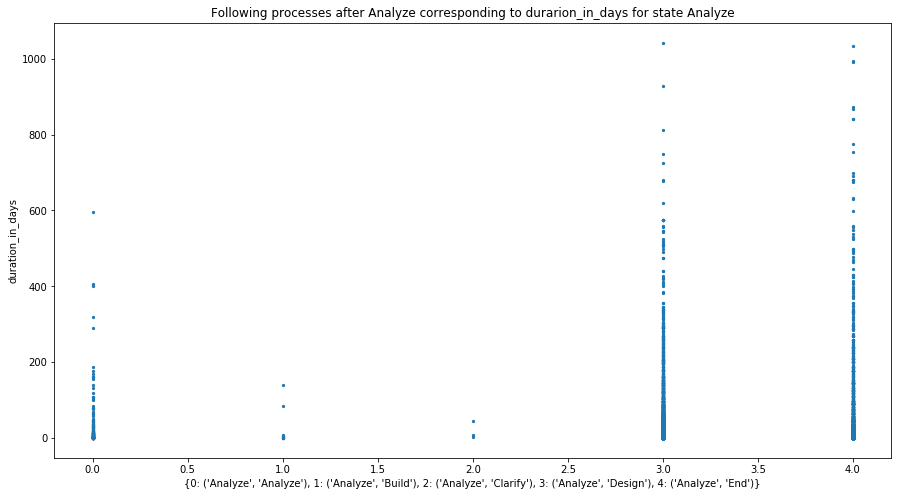

In [21]:
analyze.plot(kind="scatter", x="next_process_cat", y="duration_in_days", figsize=(15,8), s=5)
plt.xlabel(lab)
plt.title("Following processes after Analyze corresponding to durarion_in_days for state Analyze")
plt.show()

Analyze -> Design and Analyze -> End are most frequent paths but it looks like Analyze is individual and work ticket based, maybe some other feature affects the time of the state analyze, we should add a third dimension using a color

In [22]:
wt_1 = analyze[analyze["work_type_change"].apply(lambda x: "WT_00001" in str(x))]
wt_2 = analyze[analyze["work_type_change"].apply(lambda x: "WT_00002" in str(x))]
wt_3 = analyze[analyze["work_type_change"].apply(lambda x: "WT_00003" in str(x))]

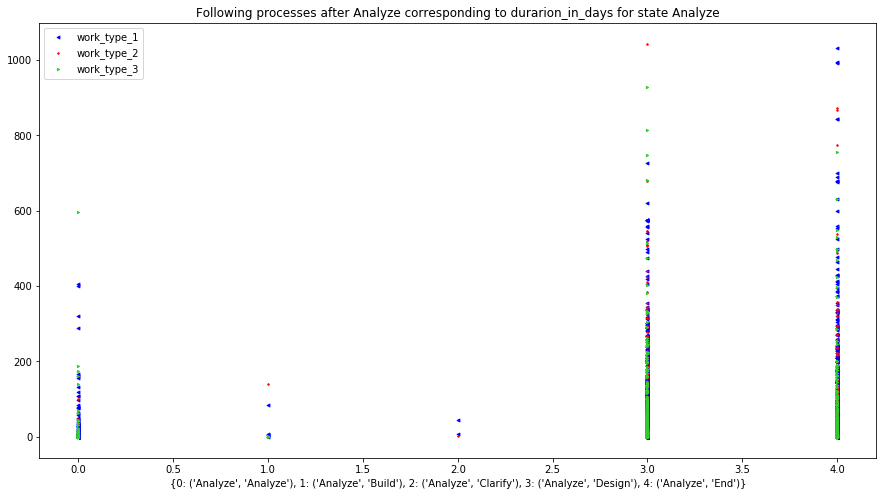

In [23]:
plt.figure(figsize=(15,8))
plt.scatter(x=wt_1["next_process_cat"], y=wt_1["duration_in_days"], s=8, marker='<', color='blue', label="work_type_1")
plt.scatter(x=wt_2["next_process_cat"], y=wt_2["duration_in_days"], s=6, marker='2', color='red', label="work_type_2")
plt.scatter(x=wt_3["next_process_cat"], y=wt_3["duration_in_days"], s=5, marker='>', color='limegreen', label="work_type_3")
plt.legend()
plt.xlabel(lab)
plt.title("Following processes after Analyze corresponding to durarion_in_days for state Analyze")
#plt.savefig("C:/Users/marcelfe/Desktop/scatter.png", dpi=800)
plt.show()

In [24]:
wp_1 = analyze[analyze["work_priority_change"].apply(lambda x: "WP_00001" in str(x))]
wp_2 = analyze[analyze["work_priority_change"].apply(lambda x: "WP_00002" in str(x))]
wp_3 = analyze[analyze["work_priority_change"].apply(lambda x: "WP_00003" in str(x))]
wp_4 = analyze[analyze["work_priority_change"].apply(lambda x: "WP_00004" in str(x))]
wp_5 = analyze[analyze["work_priority_change"].apply(lambda x: "WP_00005" in str(x))]

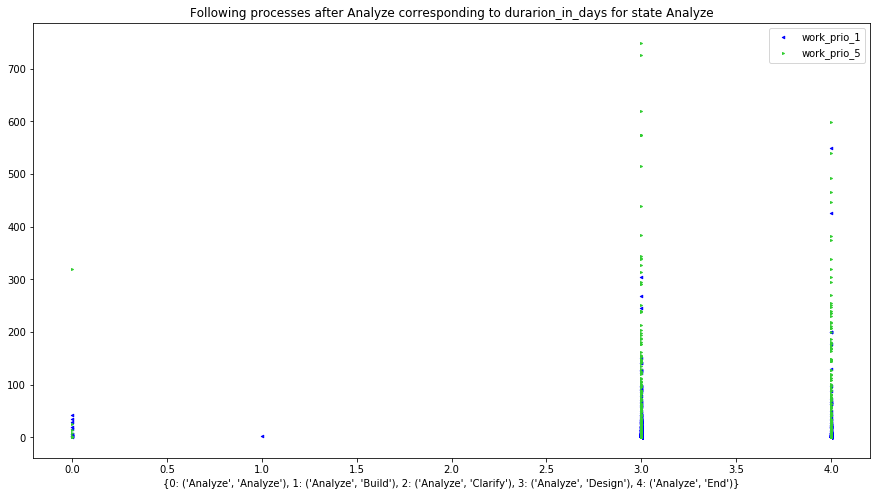

In [25]:
plt.figure(figsize=(15,8))
plt.scatter(x=wp_1["next_process_cat"], y=wp_1["duration_in_days"], s=6, marker='<', color='blue', label="work_prio_1")
#plt.scatter(x=wp_2["next_process_cat"], y=wp_2["duration_in_days"], s=markersize, marker='2', color='red', label="work_prio_2")
#plt.scatter(x=wp_3["next_process_cat"], y=wp_3["duration_in_days"], s=markersize, marker='3', color='green', label="work_prio_3")
#plt.scatter(x=wp_4["next_process_cat"], y=wp_4["duration_in_days"], s=markersize, marker='4', color='black', label="work_prio_4")
plt.scatter(x=wp_5["next_process_cat"], y=wp_5["duration_in_days"], s=4, marker='>', color='limegreen', label="work_prio_5")
plt.legend()
plt.xlabel(lab)
plt.title("Following processes after Analyze corresponding to durarion_in_days for state Analyze")
#plt.savefig("C:/Users/marcelfe/Desktop/scatter.png", dpi=800)
plt.show()

Seems like work_type doesn't have a big impact on the analyze step, while work_priority could be an indicator for the duration, lower work priorities are analyzed faster than higher ones. Could be because low priority problems are simpler than the high prios.

Let's have a look at the third question:
3. When and how often does a process come back to the state analyze

First of all we want to take a look on the phases and times in general again

In [26]:
tclosed = times_closed
tclosed.loc[:, "work_type"] = tclosed["work_type_change"].apply(lambda x: x[0])
tclosed.loc[:, "work_priority"] = tclosed["work_priority_change"].apply(lambda x: x[0])
tclosed.loc[:, "domain"] = tclosed["domain_change"].apply(lambda x: x[0])
tclosed.loc[:, "components"] = tclosed["components_change"].apply(lambda x: x[0])

In [27]:
tclosed = tclosed[["work_item", "process_index", "process_change", "current_phase", "next_process", "work_type",
                  "work_priority", "domain", "components", "duration_in_days"]]

In [28]:
tclosed["work_item"] = tclosed["work_item"].astype("category")

In [29]:
tclosed.loc[:, "duration_days_cumsum"] = tclosed.groupby("work_item")["duration_in_days"].apply(lambda x: x.cumsum())

In [30]:
analyze = tclosed[tclosed["current_phase"]=="Analyze"]
design = tclosed[tclosed["current_phase"]=="Design"]
build = tclosed[tclosed["current_phase"]=="Build"]
test = tclosed[tclosed["current_phase"]=="Test"]
package = tclosed[tclosed["current_phase"]=="Package"]
accept = tclosed[tclosed["current_phase"]=="Accept"]
deploy = tclosed[tclosed["current_phase"]=="Deploy"]

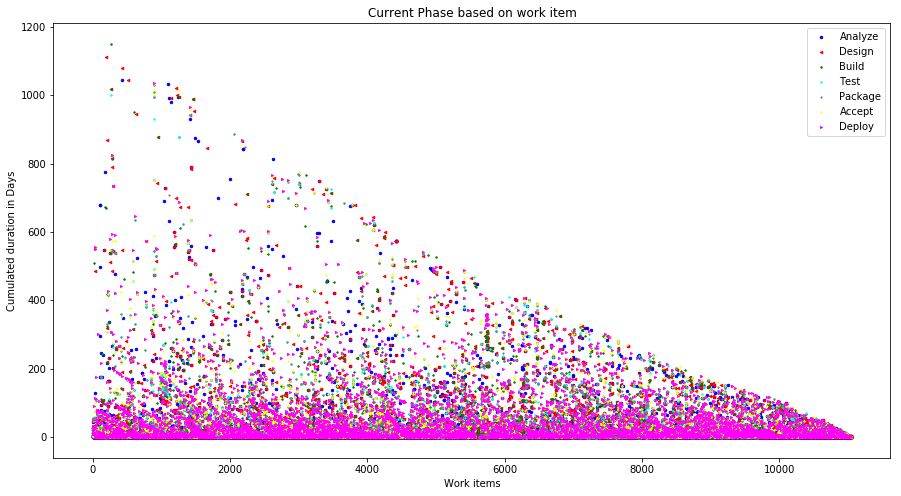

In [31]:
plt.figure(figsize=(15,8))
plt.scatter(x=analyze["work_item"].cat.codes, y=analyze["duration_days_cumsum"], s=6, color='blue', label="Analyze")
plt.scatter(x=design["work_item"].cat.codes, y=design["duration_days_cumsum"], s=6, marker='<', color='red', label="Design")
plt.scatter(x=build["work_item"].cat.codes, y=build["duration_days_cumsum"], s=6, marker='3', color='green', label="Build")
plt.scatter(x=test["work_item"].cat.codes, y=test["duration_days_cumsum"], s=6, marker='4', color='cyan', label="Test")
plt.scatter(x=package["work_item"].cat.codes, y=package["duration_days_cumsum"], s=4, marker='2', color='grey', label="Package")
plt.scatter(x=accept["work_item"].cat.codes, y=accept["duration_days_cumsum"], s=4, marker='1', color='yellow', label="Accept")
plt.scatter(x=deploy["work_item"].cat.codes, y=deploy["duration_days_cumsum"], s=4, marker='>', color='magenta', label="Deploy")
plt.legend()
plt.xlabel("Work items")
plt.ylabel("Cumulated duration in Days")
plt.title("Current Phase based on work item")
plt.show()

With these outlieres it looks like a exponential distribution with low lambda. Outliers decrease with increasing work items, the reason could be optimized processes over time, more support employees or automization. Or just because they don't have an end yet.

Let's have a closer look on the crouded range on the bottom of the plot

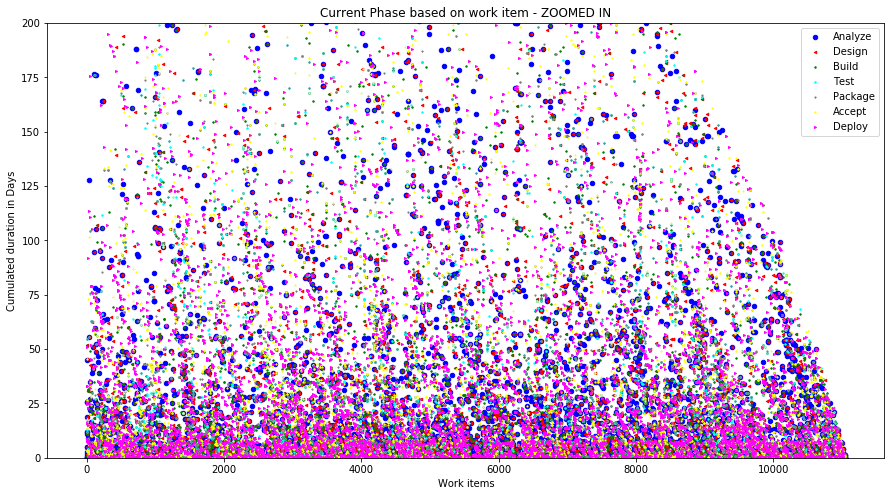

In [32]:
plt.figure(figsize=(15,8))
plt.scatter(x=analyze["work_item"].cat.codes, y=analyze["duration_days_cumsum"], s=20, color='blue', label="Analyze")
plt.scatter(x=design["work_item"].cat.codes, y=design["duration_days_cumsum"], s=6, marker='<', color='red', label="Design")
plt.scatter(x=build["work_item"].cat.codes, y=build["duration_days_cumsum"], s=6, marker='3', color='green', label="Build")
plt.scatter(x=test["work_item"].cat.codes, y=test["duration_days_cumsum"], s=6, marker='4', color='cyan', label="Test")
plt.scatter(x=package["work_item"].cat.codes, y=package["duration_days_cumsum"], s=4, marker='2', color='grey', label="Package")
plt.scatter(x=accept["work_item"].cat.codes, y=accept["duration_days_cumsum"], s=4, marker='1', color='yellow', label="Accept")
plt.scatter(x=deploy["work_item"].cat.codes, y=deploy["duration_days_cumsum"], s=4, marker='>', color='magenta', label="Deploy")
plt.legend()
plt.ylim((0,200))
plt.xlabel("Work items")
plt.ylabel("Cumulated duration in Days")
plt.title("Current Phase based on work item - ZOOMED IN")
plt.show()

We see blue dots all over the range. But we can't identify if the inital Analyze phase lasts long or it's a reccuring process, so we should restrict on the work items which have a reccuring phase

In [33]:
tclosed.loc[:, "dupl"] = tclosed.groupby("work_item")["current_phase"].apply(lambda x: x.duplicated()==True)

In [34]:
group_dupl = tclosed.groupby("work_item").apply(lambda x: True if (True in x["dupl"].values) else False)

In [35]:
dupl_df = pd.DataFrame(group_dupl).reset_index()
dupl_wi = dupl_df[dupl_df[0]==True]

In [36]:
dupl_phase = tclosed[tclosed["work_item"].apply(lambda x: x in dupl_wi["work_item"].values)]

In [37]:
analyze = dupl_phase[dupl_phase["current_phase"]=="Analyze"]
design = dupl_phase[dupl_phase["current_phase"]=="Design"]
build = dupl_phase[dupl_phase["current_phase"]=="Build"]
test = dupl_phase[dupl_phase["current_phase"]=="Test"]
package = dupl_phase[dupl_phase["current_phase"]=="Package"]
accept = dupl_phase[dupl_phase["current_phase"]=="Accept"]
deploy = dupl_phase[dupl_phase["current_phase"]=="Deploy"]

In [38]:
print("There are %i unique work items, that have a recurrent process flow" %dupl_phase.work_item.nunique())

There are 2690 unique work items, that have a recurrent process flow


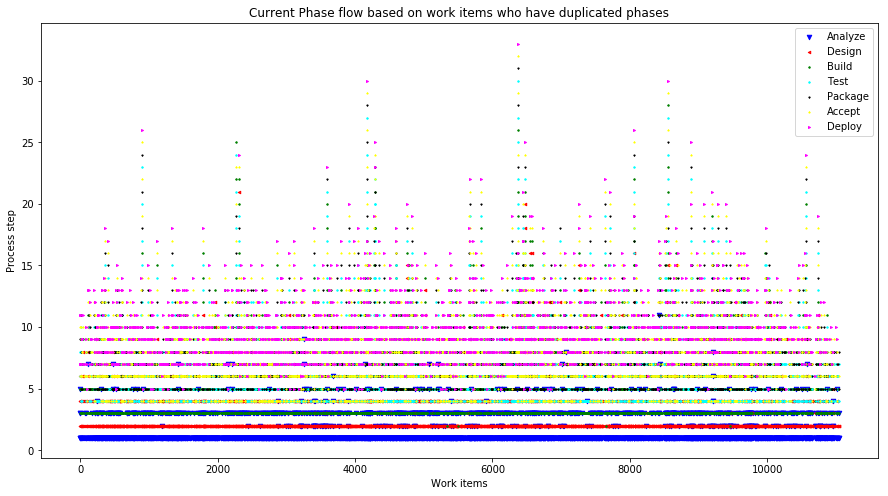

In [39]:
plt.figure(figsize=(15,8))
plt.scatter(x=analyze["work_item"].cat.codes, y=analyze["process_index"], s=20, marker='v', color='blue', label="Analyze")
plt.scatter(x=design["work_item"].cat.codes, y=design["process_index"], s=6, marker='<', color='red', label="Design")
plt.scatter(x=build["work_item"].cat.codes, y=build["process_index"], s=6, marker='3', color='green', label="Build")
plt.scatter(x=test["work_item"].cat.codes, y=test["process_index"], s=6, marker='4', color='cyan', label="Test")
plt.scatter(x=package["work_item"].cat.codes, y=package["process_index"], s=4, marker='2', color='black', label="Package")
plt.scatter(x=accept["work_item"].cat.codes, y=accept["process_index"], s=4, marker='1', color='yellow', label="Accept")
plt.scatter(x=deploy["work_item"].cat.codes, y=deploy["process_index"], s=4, marker='>', color='magenta', label="Deploy")
plt.legend()
#plt.ylim((0,5))
plt.xlabel("Work items")
plt.ylabel("Process step")
plt.title("Current Phase flow based on work items who have duplicated phases")
plt.show()

In [40]:
analyze.process_change.value_counts()

(Start, Analyze)      2690
(Design, Analyze)      731
(Analyze, Analyze)     153
(Clarify, Analyze)       2
(Build, Analyze)         2
Name: process_change, dtype: int64

In [41]:
tclosed[tclosed["process_change"].apply(lambda x: x[0]==x[1])]["process_change"].value_counts()

(Analyze, Analyze)    153
(Design, Design)       43
Name: process_change, dtype: int64

We can now answer the third question: It seems like the state Analyze comes back only once and directly after the phase of Design in most of the tickets. That is not really a big suprise because many ideas and concepts are good in theory but not feasable in an appropriate amount of time.

There are also some items where the phase value don't change, like Analyze->Analyze and Design->Design. There are columns from_resource -> to_resource in the dataset which might be the answer to this.

Also interesting: Does work items which have unique phases as many outliers as the duplicates?

In [42]:
no_dupl_df = dupl_df[dupl_df[0]==False]
no_dupl_phase = tclosed[tclosed["work_item"].apply(lambda x: x in no_dupl_df["work_item"].values)]
analyze = no_dupl_phase[no_dupl_phase["current_phase"]=="Analyze"]
design = no_dupl_phase[no_dupl_phase["current_phase"]=="Design"]
build = no_dupl_phase[no_dupl_phase["current_phase"]=="Build"]
test = no_dupl_phase[no_dupl_phase["current_phase"]=="Test"]
package = no_dupl_phase[no_dupl_phase["current_phase"]=="Package"]
accept = no_dupl_phase[no_dupl_phase["current_phase"]=="Accept"]
deploy = no_dupl_phase[no_dupl_phase["current_phase"]=="Deploy"]
print("There are %i unique work items, that have a unique process flow" %no_dupl_phase.work_item.nunique())

There are 8358 unique work items, that have a unique process flow


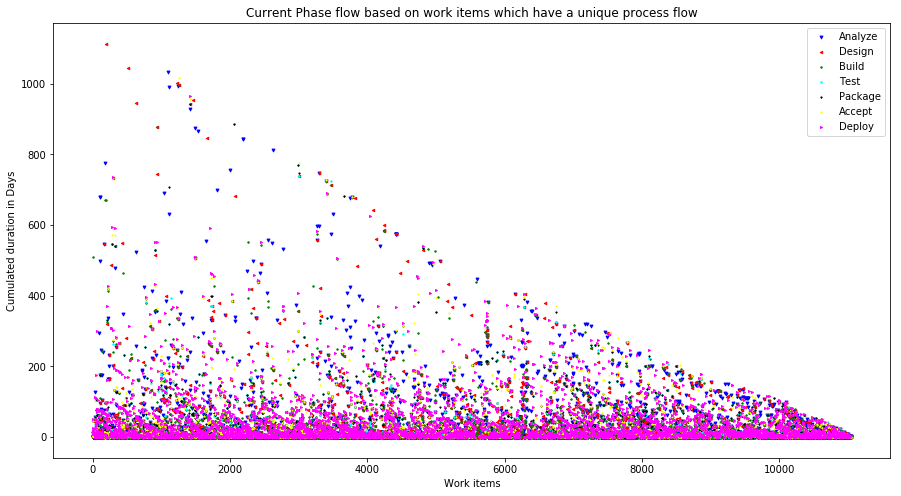

In [43]:
plt.figure(figsize=(15,8))
plt.scatter(x=analyze["work_item"].cat.codes, y=analyze["duration_days_cumsum"], s=8, marker='v', color='blue', label="Analyze")
plt.scatter(x=design["work_item"].cat.codes, y=design["duration_days_cumsum"], s=6, marker='<', color='red', label="Design")
plt.scatter(x=build["work_item"].cat.codes, y=build["duration_days_cumsum"], s=6, marker='3', color='green', label="Build")
plt.scatter(x=test["work_item"].cat.codes, y=test["duration_days_cumsum"], s=6, marker='4', color='cyan', label="Test")
plt.scatter(x=package["work_item"].cat.codes, y=package["duration_days_cumsum"], s=4, marker='2', color='black', label="Package")
plt.scatter(x=accept["work_item"].cat.codes, y=accept["duration_days_cumsum"], s=4, marker='1', color='yellow', label="Accept")
plt.scatter(x=deploy["work_item"].cat.codes, y=deploy["duration_days_cumsum"], s=4, marker='>', color='magenta', label="Deploy")
plt.legend()
#plt.ylim((0,5))
plt.xlabel("Work items")
plt.ylabel("Cumulated duration in Days")
plt.title("Current Phase flow based on work items which have a unique process flow")
#plt.savefig("C:/Users/marcelfe/Desktop/scatter.png", dpi=800)
plt.show()

The Plot look more dense than the general one, so one can assume that going back in the process takes more time to get the work done. Key fact should be the Analyze and Design, if the Analyze step is done well the Design step is doing as well and the process can go it's way. If the Analyze step isn't done well or not practical, one will become aware in the design step and have to go back to analyze the problem.
This could be an indicator that analyze and design are treated from two different employees.

We can summarize the following:
1. Every Process starts with the Phase "Analyze"
2. work_type, work_priority, domain and components are static
3. After the problem is analyzed, most of the ticket go to design or they will be closed
4. Lower work priority can be analyzed faster than high ones
5. Outliers decrease with increasing work_items
6. If a problem is analyzed multiple times it fails on the design step
7. Process Phase don't have to change in a time step